# **Introduction**

The goal of this notebook is to convert an English Sentence to its Italian counterpart. I  will implement this task by using a simple seq-2-seq model. 

In [0]:
#Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import operator
import io
import gzip
%matplotlib inline
import tensorflow
import nltk
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,LSTM,GRU,Dense,Bidirectional,Dropout,BatchNormalization,Embedding
from tensorflow.keras.layers import Conv1D,SimpleRNN,SpatialDropout1D,Concatenate

warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
#The dataset
!wget http://www.manythings.org/anki/ita-eng.zip

--2020-05-19 11:00:52--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:3033::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7345811 (7.0M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.00M  1.93MB/s    in 3.6s    

2020-05-19 11:00:56 (1.93 MB/s) - ‘ita-eng.zip’ saved [7345811/7345811]



In [0]:
!unzip ita-eng*.zip

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [0]:
!ls
!pwd

_about.txt  ita-eng.zip  ita.txt  sample_data
/content


In [0]:
language = pd.read_table('ita.txt',names=['English','Italian','Attribution'])
language.head()


,English,Italian,Attribution
0,Hi.,Ciao!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1,Run!,Corri!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
2,Run!,Corra!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
3,Run!,Correte!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Who?,Chi?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [0]:
language.drop('Attribution',axis=1,inplace=True)
language.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336614 entries, 0 to 336613
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   English  336614 non-null  object
 1   Italian  336614 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


**There are 336614 training examples, since it will take a long time to train that much examples, i will cut short the training examples.**


---

**Removing long sentence so that during padding , there won't be any waste of memory**

In [0]:
language['No: of words(English)'] = language['English'].apply(lambda x: len(x.split()))
language['No: of words(English)'].value_counts()

5     73527
6     64201
4     63081
7     43417
3     34673
8     23288
2     11352
9     11337
10     5453
11     2763
12     1211
13      815
14      446
15      354
16      139
18       72
1        72
17       71
27       39
28       37
26       33
25       29
31       28
19       25
22       23
24       20
23       20
20       14
30       14
21       13
29       11
43        7
35        6
33        4
38        4
47        4
32        3
34        2
37        2
39        2
44        1
42        1
Name: No: of words(English), dtype: int64

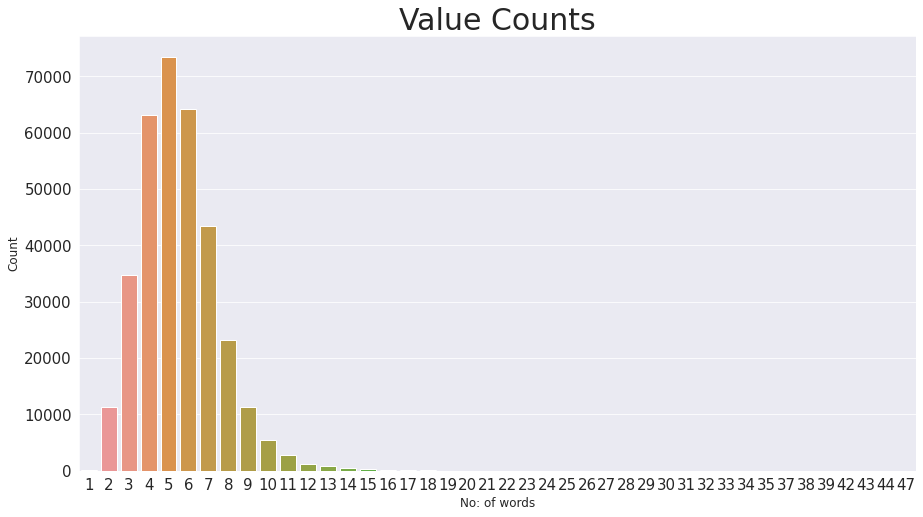

In [0]:
fig = plt.subplots(figsize=(15,8))
sns.set_style('darkgrid')
sns.barplot(x=language['No: of words(English)'].value_counts().index , y=language['No: of words(English)'].value_counts())
plt.title('Value Counts',fontdict = {'fontsize':30})
plt.xlabel('No: of words',fontdict={'fontsize':12})
plt.ylabel('Count',fontdict={'fontsize':12})
plt.tick_params(axis='both',labelsize=15)

It is clear from the above **barplot** that most sentences  have  **5** words. And also some sentences have **47** words! We should remove them because when we pad short sentences , it will be a waste of memory.

In [0]:
language = language[language['No: of words(English)']<13]
language.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334375 entries, 0 to 336171
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   English                334375 non-null  object
 1   Italian                334375 non-null  object
 2   No: of words(English)  334375 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.2+ MB


Since there are **334375** training examples, I will be cutting short the dataset since training a large dataset in a model like encoder-decoder model will take a huge amount of time.

In [0]:
language = shuffle(language)
language = language[:32000]

In [0]:
language.head(30)

,English,Italian,No: of words(English)
278049,Tom opened his beer and took a sip.,Tom ha aperto la sua birra e ne ha bevuto un s...,8
323693,He canceled the appointment at the last moment.,Annullò l'appuntamento all'ultimo momento.,8
109144,What's your objective?,Qual è il suo obiettivo?,3
206548,I thought Tom was Mary's son.,Pensavo che Tom fosse il figlio di Mary.,6
174606,I don't see any difference.,Non vedo alcuna differenza.,5
51723,Tom kept swimming.,Tom continuò a nuotare.,3
172395,Does Tom intend to help us?,Tom ha intenzione di aiutarci?,6
17352,Don't be cruel.,Non sia crudele.,3
323829,I became acquainted with your father yesterday.,Io ho fatto la conoscenza di vostro padre ieri.,7
192276,I wanted to become a doctor.,Io volevo diventare un dottore.,6


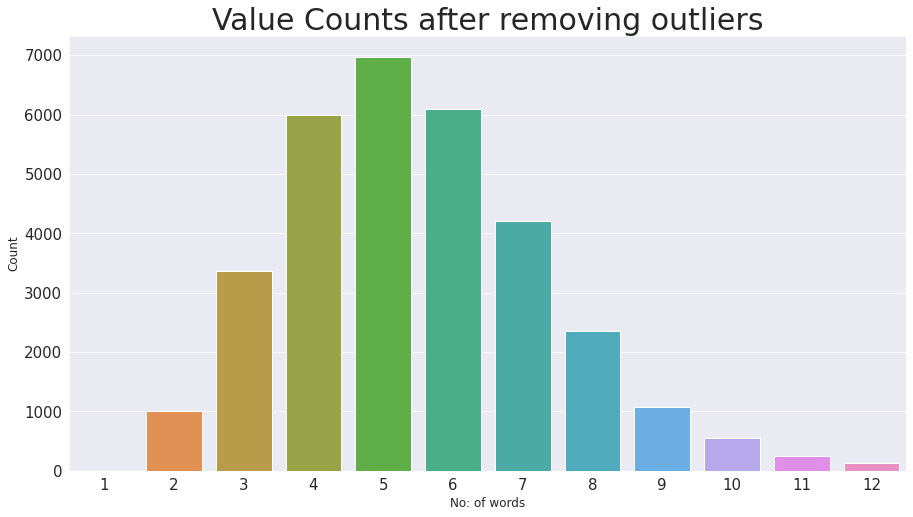

In [0]:
fig = plt.subplots(figsize=(15,8))
sns.set_style('darkgrid')
sns.barplot(x=language['No: of words(English)'].value_counts().index , y=language['No: of words(English)'].value_counts())
plt.title('Value Counts after removing outliers',fontdict = {'fontsize':30})
plt.xlabel('No: of words',fontdict={'fontsize':12})
plt.ylabel('Count',fontdict={'fontsize':12})
plt.tick_params(axis='both',labelsize=15)

It is evident from the above **barplot** that the dataset is now **less skewed** and is now **more normalized**



---
# **Data Cleaning**


In [0]:
def clean(text):

  text = text.lower()
  text = re.sub('\.','',text)
  text = re.sub('\,','',text)
  text = re.sub("[\!\?\&\@\#]",'',text)
  return text

def cleanword(text):

  text = re.sub("aren't", "are not",text)
  text = re.sub("can't","cannot",text)
  text = re.sub("don't","do not",text)
  text = re.sub("couldn't","could not",text)
  text = re.sub("doesn't","does not",text)
  text = re.sub("hadn't","had not",text)
  text = re.sub("where's","where is",text)
  text = re.sub("wouldn't","would not",text)
  text = re.sub("he'll","he will",text)
  text = re.sub("what've","what have",text)
  text = re.sub("who'd","who would",text)
  text = re.sub("haven't","have not",text)
  text = re.sub("who'll","who will",text)
  text = re.sub("i'll","i will",text)
  text = re.sub("i've","i have",text)
  text = re.sub("i'm","i am",text)
  text = re.sub("we're","we are",text)
  text = re.sub("he's","he is",text)
  text = re.sub("i'd","i would",text)
  text = re.sub("you'd","you would",text)
  text = re.sub("you'll","you will",text)
  text = re.sub("you're","you are",text)
  text = re.sub("you've","you have",text)
  text = re.sub("wasn't","was not",text)
  text = re.sub("that's","that is",text)
  text = re.sub("isn't","is not",text)
  text = re.sub("didn't","did not",text)
  text = re.sub("they've","they have",text)
  text = re.sub("they're","they are",text)
  text = re.sub("they'll","they will",text)
  text = re.sub("what's","what is",text)
  text = re.sub("what're","what are",text)
  text = re.sub("what'll","what will",text)
  text = re.sub("there's","there is",text)
  text = re.sub("it's","it is",text)
  text = re.sub("it'll","it will",text)
  text = re.sub("could've","could have",text)
  text = re.sub("it'll","it will",text)
  text = re.sub("shouldn't","should not",text)
  text = re.sub("should've","should have",text)
  text = re.sub("shan't","shall not",text)
  text = re.sub("won't","will not",text)
  text = re.sub("we'd","we would",text)
  text = re.sub("let's","let us",text)
  text = re.sub("that'll","that will",text)


  text = re.sub("weren't","were not",text)
  return text

language['English'] = language['English'].apply(lambda x: clean(x))
language['Italian'] = language['Italian'].apply(lambda x: clean(x))
language['English'] = language['English'].apply(lambda x: cleanword(x))
language['English'] = language['English'].apply(lambda x: x.strip())
language['Italian'] = language['Italian'].apply(lambda x: x.strip())
language['English'] = language['English'].apply(lambda x: re.sub(" +", " ", x))
language['Italian'] = language['Italian'].apply(lambda x: re.sub(" +", " ", x))

language['Italian'] = language['Italian'].apply(lambda x: 'start_ '+ x + ' _end')
language.head(30)

,English,Italian,No: of words(English)
125558,you need to study more,start_ ha bisogno di studiare di più _end,5
335070,the main islands of japan are hokkaido shikoku...,start_ le isole principali del giappone sono h...,11
70612,he is afraid of dogs,start_ ha paura dei cani _end,4
102092,i would do this every day,start_ io farei questo ogni giorno _end,5
332361,many students compete to get into the best uni...,start_ molti studenti competono per entrare ne...,9
64932,tom threw the dart,start_ tom ha lanciato il dardo _end,4
48956,keep following me,start_ continua a seguirmi _end,3
289755,i have never eaten chinese food before,start_ non ho mai mangiato del cibo cinese pri...,6
124565,why are you mad at tom,start_ perché sei arrabbiato con tom _end,6
215031,you do that a lot do not you,start_ lo fate molto vero _end,7


In [0]:
ps = PorterStemmer() 
lemmatizer = WordNetLemmatizer() 

def get_embedding(filename,word_index,vocab_len,dim):

  embedding_index={}
  if filename.split('.')[-1] == 'vec':
    f = open(filename,encoding='utf-8')
    for line in f:
      values = line.split()
      word = values[0]
      coeff = np.asarray(values[1:],dtype='float32')
      embedding_index[word] = coeff
    f.close()
  elif filename.split('.')[-1] == 'gz':
    f = gzip.open(filename)
    for line in f:
      values = line.split()
      word = values[0].decode(encoding='utf-8')
      coeff = np.asarray(values[1:],dtype='float32')
      embedding_index[word] = coeff
    f.close()
  embedding_matrix = np.zeros((vocab_len+1,dim))
  for word,index in tqdm(word_index.items()):
    if index>vocab_len:
      continue    
    embedding_vector = embedding_index.get(word)
    if embedding_vector is None:
      embedding_vector = embedding_index.get(lemmatizer.lemmatize(word))
    elif embedding_vector is None:
      embedding_vector = embedding_index.get(ps.stem(word))
    elif embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

  return embedding_matrix,embedding_index

In [0]:
english_corpus = np.asarray(language['English'])
tokenizer_english = Tokenizer(num_words = 25000,filters='')
tokenizer_english.fit_on_texts(english_corpus)
english_sequence = tokenizer_english.texts_to_sequences(english_corpus)

english_vocab_len = len(tokenizer_english.word_index)+1
max_english_len = max(len(s) for s in english_sequence)

In [0]:
italian_corpus_input = np.asarray(language['Italian'])
tokenizer_italian = Tokenizer(num_words=25000,filters='')
tokenizer_italian.fit_on_texts(italian_corpus_input)
italian_input_sequence = tokenizer_italian.texts_to_sequences(italian_corpus_input)

italian_vocab_len = len(tokenizer_italian.word_index)+1
max_italian_len = max(len(s) for s in italian_input_sequence )

In [0]:
# Importing the pre-trained word embeddings for english and italian!
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-05-19 11:02:23--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  12.4MB/s    in 54s     

2020-05-19 11:03:19 (12.0 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [0]:
!unzip wiki-news-300d-1M.vec*.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [0]:
!ls
!pwd

_about.txt   ita.txt	  wiki-news-300d-1M.vec
ita-eng.zip  sample_data  wiki-news-300d-1M.vec.zip
/content


In [0]:
embedding_matrix_eng,embedding_index_eng = get_embedding('wiki-news-300d-1M.vec',tokenizer_english.word_index,english_vocab_len,300)

100%|██████████| 6824/6824 [00:01<00:00, 4661.06it/s]


In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.it.300.vec.gz
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.it.vec


--2020-05-19 11:05:09--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.it.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272825284 (1.2G) [binary/octet-stream]
Saving to: ‘cc.it.300.vec.gz’

cc.it.300.vec.gz    100%[===================>]   1.18G  12.2MB/s    in 1m 40s  

2020-05-19 11:06:50 (12.1 MB/s) - ‘cc.it.300.vec.gz’ saved [1272825284/1272825284]



In [0]:
embedding_matrix_ita,embedding_index_ita = get_embedding('cc.it.300.vec.gz',tokenizer_italian.word_index,italian_vocab_len,300)

100%|██████████| 11652/11652 [00:00<00:00, 315682.24it/s]


In [0]:
# Checking how much words in english and italian was covered by the embedding word vectors
def check_coverage(vocab, embeddings_index):

  known_words = {}
  unknown_words = {}
  nb_known_words = 0
  nb_unknown_words = 0
  for word in vocab.keys():
    try:
        known_words[word] = embeddings_index[word]
        nb_known_words += vocab[word]
    except:
        unknown_words[word] = vocab[word]
        nb_unknown_words += vocab[word]
        pass
  print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
  print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
  unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

  return unknown_words


In [0]:
eng_oov = check_coverage(tokenizer_english.word_index,embedding_index_eng)

Found embeddings for 96.483% of vocab
Found embeddings for  95.372% of all text


In [0]:
eng_oov[:30]

[('achille', 6713),
 ('all"', 6684),
 ('"not', 6683),
 ('9:30', 6659),
 ("soldiers'", 6654),
 ("grandmother's", 6645),
 ("darwin's", 6636),
 ("limousine's", 6631),
 ('30%', 6568),
 ("dad's", 6565),
 ("takuboku's", 6551),
 ("aunt's", 6549),
 ('audiobook\xad', 6468),
 ('il-sung', 6463),
 ('$200', 6442),
 ("physician's", 6433),
 ("speaker's", 6421),
 ("cleaner's", 6400),
 ("moment's", 6386),
 ('yukawa', 6384),
 ('$1000', 6379),
 ("policeman's", 6320),
 ('i"', 6309),
 ('"neither', 6308),
 ('like\xa0eating', 6299),
 ('i\xa0feel', 6298),
 ('5:00', 6297),
 ('scientist"', 6279),
 ("anything's", 6264),
 ("asperger's", 6262)]

Nice! We found embeddings for **97%** of all the vocabulary!

In [0]:
oov_ita = check_coverage(tokenizer_italian.word_index,embedding_index_ita)

Found embeddings for 93.211% of vocab
Found embeddings for  91.860% of all text


In the case of the target language, we found **93%** embeddings in the vocabulary, which is pretty good.


---

Since, Google colab has only 12GB of ram , memory will be easily finished after training such a large training set. Therefore, using a generator by using the keyword **yield**


In [0]:
def generate_batch(X , y , batch_size = 128):

    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = pad_sequences(X[j:j+batch_size],maxlen = max_english_len,padding='pre')
            decoder_input_data = np.zeros((batch_size, max_italian_len),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_italian_len, italian_vocab_len),dtype='float32')
            for i,target_text in enumerate(y[j:j+batch_size]):
              for t,word in enumerate(target_text):
                if t<len(target_text)-1:
                  decoder_input_data[i,t]=word
                if t>0:
                  decoder_target_data[i,t-1,word]=1
            yield ([encoder_input_data, decoder_input_data], decoder_target_data)

In [0]:
#Splitting data into train and test set
X_train,X_test,y_train,y_test = train_test_split(english_sequence,italian_input_sequence,test_size=0.1)

# **Modelling**

**1) Training Model**

In [0]:
#Encoder
encoder_inp = Input(shape=(max_english_len,))
en_x = Embedding(english_vocab_len+1,300,weights=[embedding_matrix_eng],trainable=False)(encoder_inp)
en_x = SpatialDropout1D(0.4)(en_x)
encoder = LSTM(256,return_sequences=True,dropout=0.5)(en_x)
lstm = LSTM(256,return_state=True,dropout=0.4)
encoder_outputs,state_h,state_c = lstm(encoder)

encoder_states=[state_h,state_c]

#Decoder
decoder_inp = Input(shape=(max_italian_len,))
de_x = Embedding(italian_vocab_len+1,300,weights = [embedding_matrix_ita],trainable=False)(decoder_inp)
drop = SpatialDropout1D(0.3)
final_dex = drop(de_x)
decoder_lstm = LSTM(256,return_sequences=True,return_state=True)
# Set up the decoder, using `encoder_states` as initial state.
decoder_out,_,_ = decoder_lstm(final_dex,initial_state=encoder_states)
decoder_dense = Dense(italian_vocab_len,activation='softmax')
decoder_out = decoder_dense(decoder_out)

fullmodel = Model([encoder_inp,decoder_inp],decoder_out)
fullmodel.compile(optimizer = 'rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
fullmodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 14, 300)      2047800     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 14, 300)      0           embedding[0][0]                  
______________________________________________________________________________________________

**We can only run about 40 epochs. More than 40 epochs will result in google colab crashing, since it only provides 12GB of RAM**

In [0]:
history = fullmodel.fit(generate_batch(X_train, y_train, batch_size = 128),
                    steps_per_epoch = len(X_train)//128,
                    epochs=40,                   
                    validation_data = generate_batch(X_test, y_test, batch_size = 128),
                    validation_steps = len(X_test)//128)


In [0]:
fullmodel.save_weights('40epochsMT.h5')

In [0]:
fullmodel.load_weights('40epochsMT.h5')

**2) Inference Model**

In [0]:
encoder_model = Model(encoder_inp,encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 14, 300)           2047800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 14, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 14, 256)           570368    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 256), (None, 256) 525312    
Total params: 3,143,480
Trainable params: 1,095,680
Non-trainable params: 2,047,800
_________________________________________________________________


In [0]:
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
final_dex2 = drop(de_x)

decoder_outputs2,state_h2,state_c2 = decoder_lstm(final_dex2,initial_state=decoder_states_inputs)
decoder_states2 = [state_h2,state_c2]
decoder_outputs = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_inp]+decoder_states_inputs,[decoder_outputs]+decoder_states2)

In [0]:
word_index_eng = tokenizer_english.word_index
word_index_ita = tokenizer_italian.word_index

idx2word_eng = {v:k for k,v in word_index_eng.items()}
idx2word_ita = {v:k for k,v in word_index_ita.items()}

In [0]:
# Function to decode the input sequence
def decode_sequence(input_seq):

  states_value = encoder_model.predict(input_seq)
  target_seq = np.zeros((1,1))
  target_seq[0,0] = tokenizer_italian.word_index['start_']
  eos = tokenizer_italian.word_index['_end']
  translated_sentence =''
  stop_condition = False
  
  while not stop_condition:
    output_tokens,h,c = decoder_model.predict([target_seq]+states_value)
    sampled_token_index = np.argmax(output_tokens[0,-1,:])
    sampled_char = idx2word_ita[sampled_token_index]
    translated_sentence+=' '+sampled_char
    if(sampled_char == '_end'):
      stop_condition=True
    target_seq=np.zeros((1,1))
    target_seq[0,0]=sampled_token_index
    states_value = [h,c]

  return translated_sentence



**Let's test out the model!**

In [0]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [0]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
print('\n')
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])
print('\n')

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])


English sentence :   tom told me not to talk to mary


Actual Italian sentence :   tom mi ha detto di non parlare con mary 


Predicted Italian sentence :   tom mi ha detto di non parlare con mary 


In [0]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
print('\n')
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])
print('\n')

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])


English sentence :   he is the man you met the other day


Actual Italian sentence :   è l'uomo che avete conosciuto l'altro giorno 


Predicted Italian sentence :   lui è l'uomo che hai conosciuto l'altro giorno 


In [0]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])


English sentence :   i know you want to come home
Actual Italian sentence :   so che volete venire a casa 
Predicted Italian sentence :   so che voglio andare a casa 


In [0]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
print('\n')
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])
print('\n')

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])


English sentence :   ask tom to help you


Actual Italian sentence :   chieda a tom di aiutarla 


Predicted Italian sentence :   dica a tom di aiutare 


In [0]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
print('\n')
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])
print('\n')

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])


English sentence :   i thought i recognized this car


Actual Italian sentence :   pensavo di avere riconosciuto quest'automobile 


Predicted Italian sentence :   io pensavo di avere questa macchina 


**To make things more interesting let's convert our predicted italian sentence into english by using a library called *google trans*, to see if it has any similarities between them.**

In [0]:
!pip install googletrans

  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15777 sha256=5d1f8d3d8cd799b8e38f64d34b2b47fc262f40a29abc47108a692fbc537165fb
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans


In [0]:
from googletrans import Translator
translator = Translator()

k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
print('\n')
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])
print('\n')

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])
print('\n')
print('Predicted Italian sentence( in English)', translator.translate(decoded_sentence[:-4]).text) 

English sentence :   i am very happy to make your acquaintance


Actual Italian sentence :   sono molto contento di fare la sua conoscenza 


Predicted Italian sentence :   sono molto felice di fare la sua conoscenza 


Predicted Italian sentence( in English) I am very happy to make your acquaintance


In [0]:

k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
print('\n')
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])
print('\n')

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])
print('\n')
print('Predicted Italian sentence( in English): ', translator.translate(decoded_sentence[:-4]).text) 

English sentence :   i know tom is writing a book


Actual Italian sentence :   so che tom sta scrivendo un libro 


Predicted Italian sentence :   so che tom sta facendo un libro 


Predicted Italian sentence( in English):  I know that Tom is doing a book


In [0]:

k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
print('\n')
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])
print('\n')

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])
print('\n')
print('Predicted Italian sentence( in English): ', translator.translate(decoded_sentence[:-4]).text) 

English sentence :   how are you going


Actual Italian sentence :   come state 


Predicted Italian sentence :   come stai andando 


Predicted Italian sentence( in English):  how are you going


In [0]:

k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
print('\n')
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])
print('\n')

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])
print('\n')
print('Predicted Italian sentence( in English): ', translator.translate(decoded_sentence[:-4]).text) 


English sentence :   i am sure tom will not be arrested


Actual Italian sentence :   io sono sicuro che tom non sarà arrestato 


Predicted Italian sentence :   sono sicuro che tom non sarà visto 


Predicted Italian sentence( in English):  I'm sure that Tom will not be seen


In [0]:

k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
print('\n')
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])
print('\n')

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])
print('\n')
print('Predicted Italian sentence( in English): ', translator.translate(decoded_sentence[:-4]).text) 


English sentence :   i do not want to go back there


Actual Italian sentence :   io non voglio tornare lì 


Predicted Italian sentence :   non voglio andare lì 


Predicted Italian sentence( in English):  I do not want to go there


In [0]:

k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
print('\n')
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])
print('\n')

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])
print('\n')
print('Predicted Italian sentence( in English): ', translator.translate(decoded_sentence[:-4]).text) 


English sentence :   i want what is best for tom


Actual Italian sentence :   io voglio ciò che è meglio per tom 


Predicted Italian sentence :   io so cosa sta bene a tom 


Predicted Italian sentence( in English):  I know what's good for tom


In [0]:

k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
print('\n')
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])
print('\n')

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])
print('\n')
print('Predicted Italian sentence( in English): ', translator.translate(decoded_sentence[:-4]).text) 


English sentence :   i will not let you go


Actual Italian sentence :   io non ti lascerò andare 


Predicted Italian sentence :   non ti lascerò andare 


Predicted Italian sentence( in English):  not let you go


In [0]:

k+=1
(input_seq, actual_output), _ = next(val_gen)
english_sentence = ''
for i in  X_test[k]:
  english_sentence+= ' '+idx2word_eng[i]

print('English sentence : ',english_sentence)
print('\n')
italian_sentence =''
for i in y_test[k]:
  italian_sentence+= ' '+idx2word_ita[i]
print('Actual Italian sentence : ' , italian_sentence[7:-4])
print('\n')

decoded_sentence = decode_sequence(input_seq)
print('Predicted Italian sentence : ',decoded_sentence[:-4])
print('\n')
print('Predicted Italian sentence( in English): ', translator.translate(decoded_sentence[:-4]).text) 


English sentence :   it was three years ago


Actual Italian sentence :   era tre anni fa 


Predicted Italian sentence :   era tre anni fa 


Predicted Italian sentence( in English):  It was three years ago


**Wow! Even though the model was only trained for 40 epochs(Memory issues), it produces good results!**